# run under oephys env

## Modules and Functions

In [57]:
import sys
import os
# Add the directory to the system path
sys.path.append('C:/Users/BingShiuan/OneDrive - Harvard University/桌面/rotatoin labs/farrell/ErniePlaceCells')
# Now you can import the module/file and use its functions
import BayesianDecoder as bayes
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.ndimage import gaussian_filter1d as gauss
from open_ephys.analysis import Session

from scipy.stats import zscore
import pandas as pd
import shutil
import subprocess
from pathlib import Path

def Encoder2pos(chA, chB, th):
    chA = (chA > th) * 1
    chB = (chB > th) * 1
    chA_plus_minus = (chA * 2) - 1
    chB_diff = np.concatenate(([0], np.diff(chB)))
    chA_prod = chA_plus_minus * chB_diff
    chB_plus_minus = (chB * 2) - 1
    chA_diff = np.concatenate(([0], np.diff(chA)))
    chB_prod = -chB_plus_minus * chA_diff
    position = np.cumsum(chA_prod + chB_prod)
    return (position/4) * (44.8/256) #circumfence in cm divided number of pulses per revolution


def zscore_activity(trace, NN=False, percentile=20):
    """
    Z-score calcium or deconvolved spikes.
    
    Parameters
    ----------
    trace : np.ndarray
        1D (time,) or 2D (n_cells, time) array.
    NN : bool
        If False: z-score calcium using `percentile` as baseline.
        If True : standard z-score, then clip negatives to 0 (for deconvolved spikes).
    percentile : float
        Percentile used as baseline when NN is False (default: 20).
    
    Returns
    -------
    z : np.ndarray
        Z-scored (and optionally non-negative) trace, same shape as `trace`.
    """
    x = np.asarray(trace)

    if x.ndim not in (1, 2):
        raise ValueError("trace must be 1D or 2D array")

    if NN:
        # Standard z-score per trace/cell, then non-negative
        if x.ndim == 1:
            mu = np.mean(x)
            sigma = np.std(x)
            if sigma == 0:
                sigma = 1.0
            z = (x - mu) / sigma
            z = np.clip(z, 0, None)
        else:  # 2D: (n_cells, time)
            mu = np.mean(x, axis=1, keepdims=True)
            sigma = np.std(x, axis=1, keepdims=True)
            sigma[sigma == 0] = 1.0
            z = (x - mu) / sigma
            z = np.clip(z, 0, None)

    else:
        # Percentile-based baseline (for calcium)
        if x.ndim == 1:
            baseline = np.percentile(x, percentile)
            baseline_mask = x <= baseline
            sigma = np.std(x[baseline_mask])
            if sigma == 0:
                sigma = 1.0
            z = (x - baseline) / sigma
        else:  # 2D: (n_cells, time)
            baseline = np.percentile(x, percentile, axis=1, keepdims=True)
            baseline_mask = x <= baseline
            # std over baseline values per cell (avoid mixing with non-baseline)
            # use nan masking for convenience
            baseline_vals = np.where(baseline_mask, x, np.nan)
            sigma = np.nanstd(baseline_vals, axis=1, ddof=0)
            sigma[sigma == 0] = 1.0
            sigma = sigma[:, None]
            z = (x - baseline) / sigma

    return z
def normalize_dim(data, axis):
    """
    Normalizes a numpy array along a specified dimension (axis) to the [0, 1] range.

    Args:
        data (np.ndarray): The input array.
        axis (int): The dimension along which to normalize.

    Returns:
        np.ndarray: The normalized array.
    """
    # Calculate min and max along the specified axis, keeping dimensions for broadcasting
    min_vals = np.min(data, axis=axis, keepdims=True)
    max_vals = np.max(data, axis=axis, keepdims=True)
    
    # Apply the min-max normalization formula
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data

import imageio_ffmpeg

def crop_with_ffmpeg(input_path, output_path, x, y, w, h, q=5):
    """
    Crop ROI and convert to grayscale, then save as AVI with MJPEG (fast).
    - x,y,w,h: ROI in pixels (top-left + width/height)
    - q: MJPEG quality (1=best/largest, 31=worst/smallest). 3–8 is common.
    """
    ffmpeg = imageio_ffmpeg.get_ffmpeg_exe()

    # MJPEG is happier with even dimensions too; also avoids some edge-case issues.
    x -= x % 2
    y -= y % 2
    w -= w % 2
    h -= h % 2
    w = max(w, 2)
    h = max(h, 2)

    vf = f"crop={w}:{h}:{x}:{y},format=gray"

    cmd = [
        ffmpeg, "-y",
        "-i", str(input_path),
        "-vf", vf,
        "-c:v", "mjpeg",
        "-q:v", str(q),
        "-an",                 # no audio (often simplest for analysis videos)
        str(output_path),
    ]

    print("Running:\n ", " ".join(cmd))
    p = subprocess.run(cmd, text=True, capture_output=True)
    if p.returncode != 0:
        print("\n--- ffmpeg stderr ---\n", p.stderr)
        raise RuntimeError(f"ffmpeg failed with code {p.returncode}")

    print("Saved:", output_path)
from pathlib import Path

def list_all_folders_pathlib(directory_path):
    """Lists all immediate subfolders in a given directory."""
    path = Path(directory_path)
    # Use iterdir() to get all items and is_dir() to filter for directories
    folders = [item.name for item in path.iterdir() if item.is_dir()]
    return folders

# linear to circular position
def lin2circ(hall, hall_th, pos):
    hall_binary = np.where(hall < hall_th, 1, 0)
    hall_def = hall_binary[1:] - hall_binary[:-1]
    loop_start = np.where(hall_def== 1)[0]
    if len(loop_start)==0:
        pos_offset1 = pos
        loop_len=[]
    else:

        pos_offset = pos - pos[loop_start[0]]
        previous_off = loop_start[0]
        loop_len=[]

        pos_offset1 = pos_offset.copy()
        pos_offset2 = pos_offset.copy()
        for idx in np.concatenate((loop_start,[0])): #from second offset
            if idx != loop_start[0]:
                pos_offset1_copy = pos_offset1.copy()
                pos_offset1[previous_off:] -= pos_offset1_copy[previous_off]
                loop_len.append(pos_offset1_copy[previous_off])
                previous_off=idx
        # rescue the missed hall sensing (not yet finished)
            #get mean loop length
        loop_len = np.asarray(loop_len, dtype=float) 
        loop_miss = np.where(loop_len-np.median(loop_len) > 100)[0] #only consider twice length (miss once)
        loop_len_adjust = loop_len.copy()
        loop_len_adjust[loop_miss] = loop_len[loop_miss]/2
        loop_len_mean = np.mean(loop_len_adjust[1:])
        #find the skipped points
    # offset_inferred=[]
    # for m in loop_miss:
    #     missed_period = pos_offset1[loop_start[m]:loop_start[m+1]]
    #     min_index = np.argmin(missed_period-loop_len_mean)
    #     offset_inferred.append(min_index+loop_start[m])


        pos_offset1[:loop_start[0]] += loop_len_mean
        print(loop_len)
    plt.plot(pos_offset1, color='k', linewidth=2)
    # plt.plot(pos_offset2[0:500000], color='r', linewidth=2)
    # plt.scatter(loop_start[0],0)
    # plt.scatter(offset_inferred,np.zeros(len(offset_inferred))+loop_len_mean)
    # plt.xlim(0, 500000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    return pos_offset1, loop_len

# sync to 2P
def sync2P(F_all,twoP_TTL,oephys_data):
    cal_frames = F_all.shape[1]

    twoP_TTL_binary = np.where(twoP_TTL>20000, 1, 0)

    TTL_def = twoP_TTL_binary[:-1] - twoP_TTL_binary[1:]
    TTL_time = np.where(TTL_def == -1)[0] #high threshold, missing TTL when it takes two frames to complete an edge. Currently recoverved by adding pulse. Should find other smarter ways.
    TTL_interval = TTL_time[1:] - TTL_time[:-1] 

    print(cal_frames)
    print(TTL_time.shape[0])
    print(TTL_interval.max(),TTL_interval.min(),np.median(TTL_interval))
    if (TTL_interval.max() - TTL_interval.min()) >1:
        print("missing TTL")
    ds_oephys_data = oephys_data[:,TTL_time]
    if cal_frames > ds_oephys_data.shape[1]:
        print("OpenEphys truncated")
        F_all_trunc = F_all[:,0:ds_oephys_data.shape[1]]
    elif  cal_frames < ds_oephys_data.shape[1]:
        print("Calcium truncated")
        F_all_trunc = F_all
        ds_oephys_data = ds_oephys_data[:,0:cal_frames]
    else: 
        print("perfectly matched!!")
        F_all_trunc = F_all

    print(F_all_trunc.shape[1])
    print(ds_oephys_data.shape[1])
    plt.plot(ds_oephys_data[0])
    return F_all_trunc, ds_oephys_data

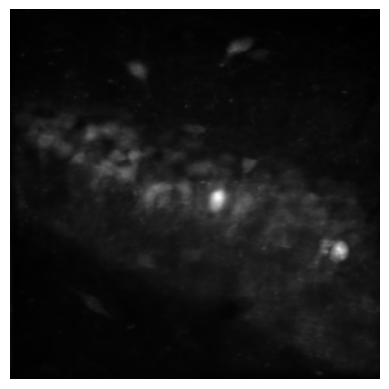

(99, 80000)
[30000 80000]


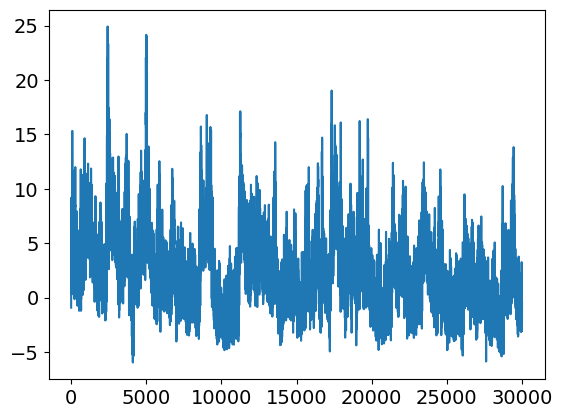

In [88]:
#Calcium data (suite2p)
# dates = ["20260112","20260114"]
# trial = [2,1]

# dates = ["20260203","20260204","20260204","20260205"]
# trial = [1,1,2,1]
# exper = [0,0,0,0]

dates = ["20260209","20260209"]
trial = [1,2]
exper = [0,0]

# dates = ["20260211"]
# trial = [1]
# exper = [0]

# foldername = r'C:/Users/BingShiuan/OneDrive - Harvard University/桌面/rotatoin labs/farrell/2P/DK047/251215/session 1/Calcium/suite2p/plane0'  # <-- change to your folder
# foldername = r'G:/共用雲端硬碟/Lab Resources/Data/Dennis/2P/DK47/0112_0114 suite2p/suite2p/plane0'
# foldername = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/suite2p/suite2p/plane0'
foldername = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/BW03 inday stim/20260209/suite2p/plane0'
# foldername = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/BW03 DG stim/20260211/1/suite2p/plane0'
# foldername = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/KNE031 CA2/20260211/2/suite2p/plane0'

F_concat_all = np.load(foldername+'/F.npy')
Fneu_concat_all = np.load(foldername+'/Fneu.npy')
spks_concat = np.load(foldername+'/spks.npy')

F_use = F_concat_all#-(2*Fneu_concat_all)

iscell = np.load(foldername+'/iscell.npy')
ops = np.load(foldername+'/ops.npy', allow_pickle=True).item()
meanImg = ops['meanImg'] 
plt.imshow(meanImg, cmap='gray')
plt.axis('off')
plt.show()
print(F_concat_all.shape)
#chunk
frame_each = ops['frames_per_file']
# frame_each = ops['frames_per_run']
frame_cum = np.cumsum(frame_each)
print(frame_cum)
F_zs_each = {}
prev_frame = 0
if len(dates)==len(frame_cum):
    for i in range(len(dates)):
        F_each = F_use[np.where(iscell[:,0] == 1),prev_frame:frame_cum[i]]
        F_zs_each[i] = zscore_activity(F_each[0],NN=False,percentile=30)
        prev_frame = frame_cum[i]
else:
    print("data not match")
plt.plot(F_zs_each[0][1,:])


xoff = ops.get('xoff', None)
yoff = ops.get('yoff', None)

xoff1 = ops.get('xoff1', None)  # non-rigid blocks (if enabled)
yoff1 = ops.get('yoff1', None)

In [89]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = np.asarray(F_zs_each[0].T)

# Standardize features (very common for PCA)
Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

pca = PCA(n_components=5)  # or float like 0.95 to keep 95% variance
Z = pca.fit_transform(Xz)  # scores, shape (n_samples, n_components)

explained = pca.explained_variance_ratio_
components = pca.components_        # loadings, shape (n_components, n_features)

print("Explained variance ratio:", explained)


Explained variance ratio: [0.27216095 0.12226752 0.06395002 0.05283184 0.03836429]


In [8]:
print(F_raw.shape)

(50000,)


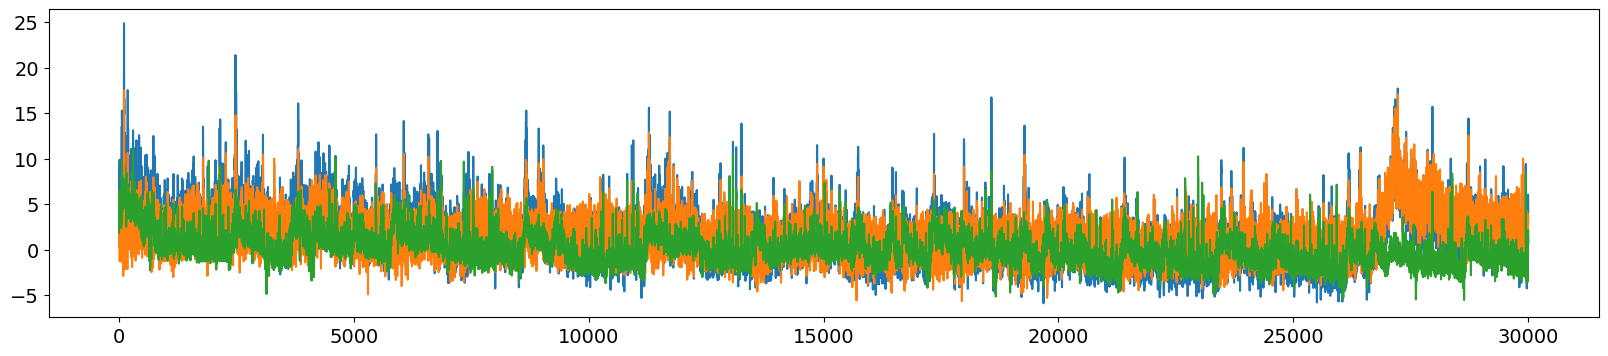

In [90]:
#regress out motion

cell = 6

F_raw = F_zs_each[0][cell,:]
reg =  Z[:,0]
# fit and remove only motion-related part (keep intercept/mean)
beta = np.dot(reg, F_raw) / np.dot(reg, reg)              # (P, N)
F_clean = F_raw - reg * beta                        # regress out motion terms
plt.figure(figsize=(20, 4))
plt.plot(F_raw)
plt.plot(F_clean)
plt.plot(reg* beta)
plt.show()

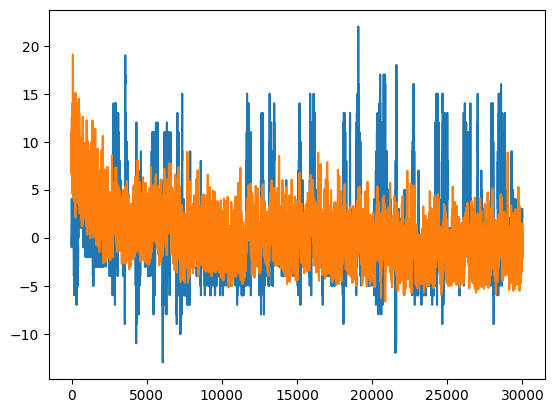

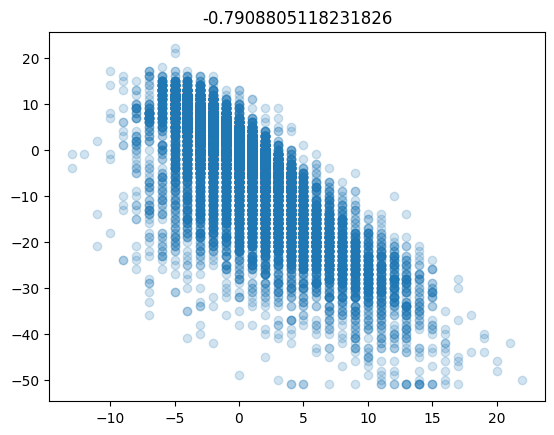

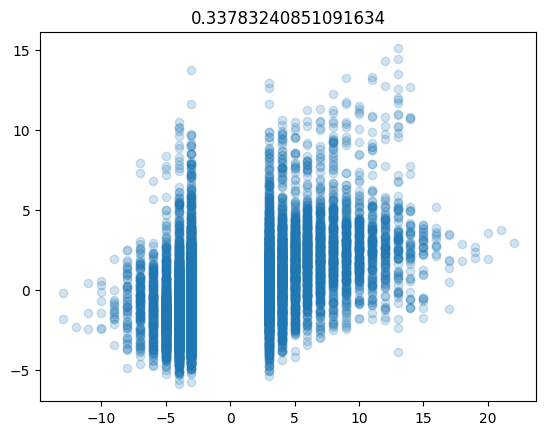

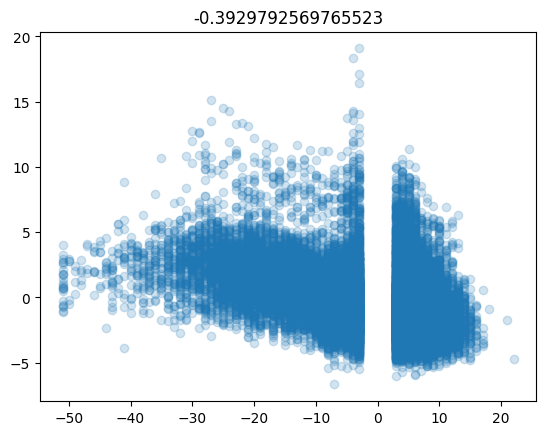

In [50]:

# xoff=xoff[0:50000]
# yoff=yoff[0:50000]
cell = 4
plt.plot(xoff)
# plt.plot(yoff)
# plt.plot(F_zs_each[0][cell,:])
plt.plot(Z[:,0])
# plt.xlim([5000,10000])
plt.show()

plt.scatter(xoff,yoff,alpha = 0.2)
corr1 = np.corrcoef(xoff, yoff)[0, 1]
plt.title(str(corr1))
plt.show()

cutoff = 2
plt.scatter(xoff[abs(xoff)>cutoff],Z[abs(xoff)>cutoff,0],alpha = 0.2)
corr3 = np.corrcoef(xoff[abs(xoff)>cutoff],Z[abs(xoff)>cutoff,0])[0, 1]
plt.title(str(corr2))
plt.show()

cutoff = 2
plt.scatter(yoff[abs(yoff)>cutoff],Z[abs(yoff)>cutoff,0],alpha = 0.2)
corr3 = np.corrcoef(yoff[abs(yoff)>cutoff],Z[abs(yoff)>cutoff,0])[0, 1]
plt.title(str(corr3))
plt.show()

Open Ephys GUI Recording
ID: 0x2c7657d4410
Format: Binary
Directory: G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/BW03 inday stim/20260209/1/2026-02-09_18-10-01\Record Node 103\experiment1\recording2
Experiment Index: 0
Recording Index: 0
[  0.      150.5     150.675   150.19375 150.5     150.7625  150.2375
 150.63125 150.54375 150.28125 150.5875 ]


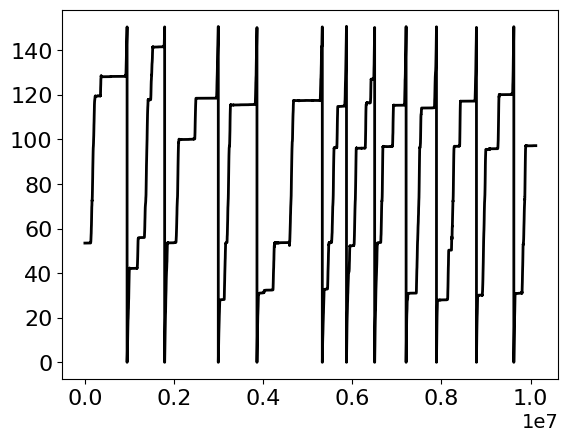

30000
30000
331 330 331.0
perfectly matched!!
30000
30000
Open Ephys GUI Recording
ID: 0x2c76569e110
Format: Binary
Directory: G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/BW03 inday stim/20260209/2/2026-02-09_18-10-01\Record Node 103\experiment2\recording2
Experiment Index: 0
Recording Index: 0
[  0.      150.45625 150.45625 150.19375 150.36875 150.45625 150.2375
 150.325   150.54375 150.15    150.5875  150.10625 150.2375  150.4125
 150.19375 150.5     150.36875 150.2375  150.2375  150.4125  150.45625
 150.2375  150.71875 150.36875 150.15   ]


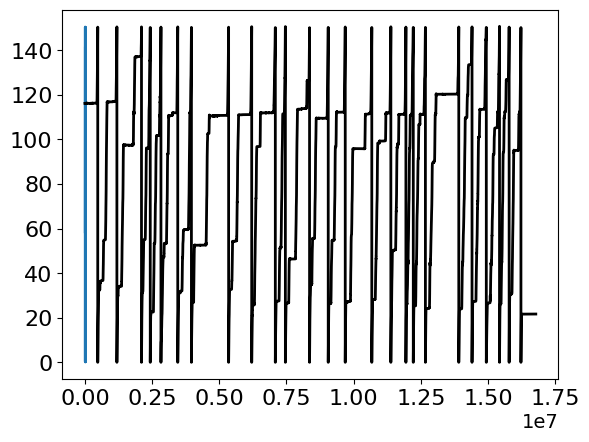

50000
50000
331 330 331.0
perfectly matched!!
50000
50000


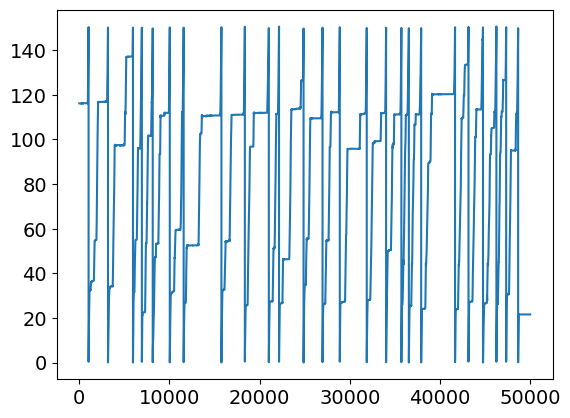

In [91]:
#Behavior data (openephys)
F_all_trunc, ds_oephys_data={},{}
for d in range(len(dates)):

    # data_dir = r'C:/Users/BingShiuan/OneDrive - Harvard University/桌面/rotatoin labs/farrell/2P/DK047/251215/session 1/Openephys/2025-12-15_17-49-34'  # <-- change to your folder
    # data_dir = r'G:/共用雲端硬碟/Lab Resources/Data/Dennis/2P/DK47/'+dates[d]+'/'+str(trial[d])+'/'  # <-- change to your folder
    # data_dir = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0122 stim slice/2026-01-22_18-15-24'
    data_dir = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/BW03 inday stim/'+str(dates[d])+'/'+str(trial[d])+'/'  # <-- change to your folder
    # data_dir = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/BW03 DG stim/'+str(dates[d])+'/'+str(trial[d])+'/'  # <-- change to your folder
    # data_dir = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/KNE031 CA2/'+str(dates[d])+'/'+str(trial[d])+'/'  # <-- change to your folder
    subfolder = list_all_folders_pathlib(data_dir)
    matches = [x for x in subfolder if str(dates[d][0:4]) in x]
    data_path = data_dir+matches[0]
    session = Session(data_path)   # detects Binary/OpenEphys/NWB automatically

    # If you only have one Record Node:
    exp = exper[d]
    recordings = session.recordnodes[0].recordings

    rec0 = recordings[exp]          # first recording #which experiment?
    cont0 = rec0.continuous[0]    # first continuous stream

    data = cont0.samples          # numpy array, shape (n_samples, n_channels)
    fs = cont0.metadata.sample_rate
    t = np.arange(data.shape[0]) / fs   # time vector in seconds


    chB = data[:, 1]  #need to check A and B
    chA = data[:, 2]
    hall = data[:, 3]
    camera_pulse = data[:,4]
    led = data[:,5] #ch6
    stim = data[:,7] #ch8
    twoP_TTL = data[:, 0] 
    pos = Encoder2pos(chA, chB, 1000)
    speed = gauss(np.concatenate( (np.array([0]), pos[1:] - pos[:-1])) * fs, 500)
    speed = np.abs(speed)
    time=np.arange(0,len(speed))/(fs)
    hall_th = 15000
    print(recordings[exp])

    # processing
    [pos_offset, loop_len]=lin2circ(hall,hall_th,pos)
    # oephys_data = np.vstack((pos_offset, speed))
    oephys_data = np.vstack((pos_offset, speed,stim))
    F_all_trunc[d], ds_oephys_data[d] = sync2P(F_zs_each[d],twoP_TTL,oephys_data)


2 667 333.0
7387436


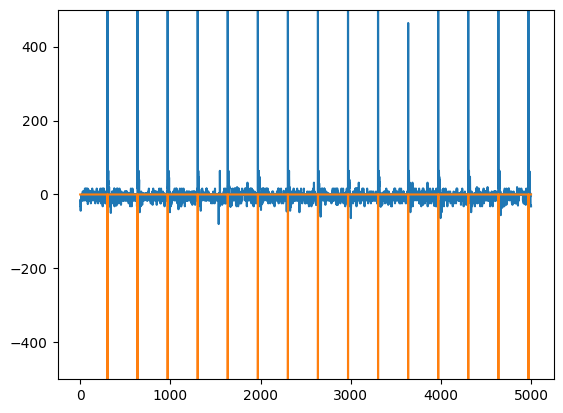

In [217]:

w = 30

med = pd.Series(camera_pulse).rolling(window=w, center=False).median().to_numpy()
# med = np.median(camera_pulse)
camera_pulse_offset = camera_pulse - med

cam_pulse_binary = (camera_pulse_offset>250)*1
cam_pulse_def = cam_pulse_binary[1:] - cam_pulse_binary[:-1]
cam_pulse_time = np.where(cam_pulse_def== 1)[0]
cam_pulse_interval = cam_pulse_time[1:] - cam_pulse_time[:-1] 
show = range(12890000,12895000)
plt.plot(camera_pulse_offset[show])
plt.plot(cam_pulse_binary[show]*-1000)
plt.ylim([-500,500])
print(min(cam_pulse_interval),max(cam_pulse_interval),np.median(cam_pulse_interval))
print(cam_pulse_time[np.argmin(cam_pulse_interval)])

In [93]:

from scipy.ndimage import gaussian_filter1d

ROI = [33,33]
for t in [0,1]:
    # F_all_zs = zscore_activity(F_all_trunc[t],NN=False,percentile=50)
    F_sm_zs = gaussian_filter1d(F_all_trunc[t], axis=1, sigma=1)
    
    fig = plt.figure(figsize=(16,20))
    # plt.plot(ds_led/2000)
    ds_stim = ds_oephys_data[t][2,:]
    # plt.plot(ds_stim/2000)


    print(target)
    ds_stim_bin = (ds_stim>10000)*1
    stim_bin_def = ds_stim_bin[1:] - ds_stim_bin[:-1]
    stim_time = np.where(stim_bin_def== 1)[0]
    stim_time_def = stim_time[1:] - stim_time[:-1] #to find false dipping because of down sampling
    short_interval = np.where(stim_time_def<33)[0]
    print(short_interval)
    stim_time = np.delete(stim_time, short_interval+1)
    offset = 15  # vertical spacing (change this)
    for i in range(F_sm_zs.shape[0]):
        if i==target[0]:
            c = "r"
        else:
            c = "gray"
        plt.plot(F_sm_zs[i,:] + (i+2) * offset, color=c)
    plt.plot(ds_oephys_data[t][0,:]/3-offset*3)

    for x0 in stim_time:
        plt.axvline(x=x0, linestyle="--", color="orange")
        plt.axvspan(x0, x0+30, alpha=0.25, color="orange") 
        
    # plt.xlim([25000,28000])
    plt.show

    fig.savefig(foldername+"/plot"+str(t)+".svg", format="svg")  # <- save as SVG


NameError: name 'target' is not defined

<Figure size 1600x2000 with 0 Axes>

In [222]:
print(peristimF_3d.shape)

(45, 49, 90)


In [223]:
m=np.mean(peristimF_3d,axis=0)
print(m.shape)

(49, 90)


In [92]:
## align to certain position per lap
fr=30
l=1
r=2
window = np.array([stim_time-fr*l,stim_time+fr*r])
x = np.arange(-l,r,1/fr)
peristimF=[]
# peristimOephys=[]
for st in range(len(stim_time)-1):
    peristimF.append(F_all_trunc[1][:,window[0,st+1]:window[1,st+1]])
    # peristimOephys.append(ds_oephys_data[1][:,window[0,st+1]:window[1,st+1]])
peristimF_3d = np.array(peristimF)
# peristimOephys_3d = np.array(peristimOephys)

ds_pos = ds_oephys_data[1][0,:]
plt.hist(ds_pos,bins=np.arange(0,140,5))
plt.show()
plt.hist(ds_pos[stim_time],bins=np.arange(0,140,5),color="orange")
plt.show()



cell = target[0][0]
# cell = 17
h=plt.imshow(peristimF_3d[:,cell,:],cmap='hot')
plt.colorbar(h, orientation='horizontal',location='top')
plt.axvline(31, linestyle="--", color="k")
plt.show()


y=np.mean(peristimF_3d[:,cell,:],axis=0)
err=np.std(peristimF_3d[:,cell,:],axis=0)/np.sqrt(peristimF_3d[:,cell,:].shape[0])
plt.plot(x,y,'b')

plt.fill_between(x,y-err, y+err, color='b', alpha=0.5,linewidth=0)
plt.show()

h=plt.imshow(np.mean(peristimF_3d,axis=0),cmap='gist_heat')
plt.colorbar(h, orientation='horizontal',location='top')
plt.axvline(31, linestyle="--", color="k")
plt.show()

NameError: name 'stim_time' is not defined

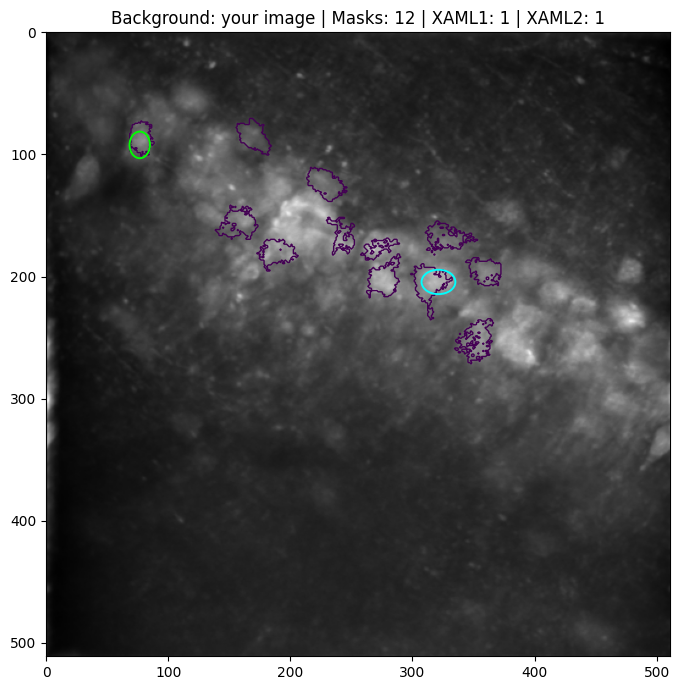

Saved: G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/overlay_myimage_masks_ellipses.svg


In [66]:
from matplotlib.patches import Ellipse
import xml.etree.ElementTree as ET
from pathlib import Path

# ---------- Load your image (png/jpg/tif/npy) ----------
def load_image_any(path: str) -> np.ndarray:
    p = Path(path)
    suf = p.suffix.lower()

    if suf == ".npy":
        img = np.load(p)
        return img

    if suf in [".tif", ".tiff"]:
        import imageio.v3 as iio
        img = iio.imread(p)
        if img.ndim == 3:  # stack -> first frame
            img = img[0]
        return img

    img = plt.imread(p)  # png/jpg
    if img.ndim == 3:    # RGB/RGBA -> grayscale for display
        img = img[..., :3].mean(axis=-1)
    return img

# ---------- Read ellipses from XAML ----------
def strip_ns(tag: str) -> str:
    return tag.split("}", 1)[-1] if "}" in tag else tag

def parse_xy(s: str):
    a, b = s.split(",")
    return float(a), float(b)

def read_roie_llipses_from_xaml(xaml_path: str):
    tree = ET.parse(xaml_path)
    root = tree.getroot()
    ellipses = []
    for elem in root.iter():
        if strip_ns(elem.tag) == "ROIEllipse":
            cx, cy = parse_xy(elem.attrib["Center"])
            w = float(elem.attrib["ROIWidth"])
            h = float(elem.attrib["ROIHeight"])
            lw = float(elem.attrib.get("StrokeThickness", 2.0))
            ellipses.append((cx, cy, w, h, lw))
    return ellipses

# ---------- Load suite2p + build masks ----------
def load_suite2p_plane(plane0_dir: str):
    plane0 = Path(plane0_dir)
    ops  = np.load(plane0/"ops.npy",  allow_pickle=True).item()
    stat = np.load(plane0/"stat.npy", allow_pickle=True)
    iscell_path = plane0/"iscell.npy"
    iscell = np.load(iscell_path, allow_pickle=True) if iscell_path.exists() else None
    return ops, stat, iscell

def build_roi_masks(stat, Ly: int, Lx: int, use_iscell=None, iscell=None):
    n = len(stat)
    if use_iscell is None or iscell is None:
        idx = np.arange(n)
    else:
        flag = (iscell[:, 0] == 1)
        idx = np.where(flag if use_iscell else ~flag)[0]

    masks = np.zeros((len(idx), Ly, Lx), dtype=bool)
    for k, i in enumerate(idx):
        s = stat[i]
        y = s["ypix"].astype(int)
        x = s["xpix"].astype(int)
        masks[k, y, x] = True
    return masks, idx

# ---------- Nearest-neighbor resize for masks (no extra deps) ----------
def resize_mask_nn(mask2d: np.ndarray, out_h: int, out_w: int) -> np.ndarray:
    in_h, in_w = mask2d.shape
    yy = (np.linspace(0, in_h - 1, out_h)).astype(int)
    xx = (np.linspace(0, in_w - 1, out_w)).astype(int)
    return mask2d[yy[:, None], xx[None, :]]

# ===================== USER SETTINGS =====================
image_path = r"G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/STD_reg_tif.png"          # <-- your background image
plane0_dir = r"G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/suite2p/suite2p/plane0"          # <-- suite2p output folder
xaml_1     = r"G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/3/BleachROIs.xaml"
xaml_2     = r"G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/4/BleachROIs.xaml"

# If your XAML ellipses were drawn on the CROPPED suite2p view (ops['yrange'], ops['xrange']),
# set this True to shift them into full-frame coordinates before scaling.
xaml_is_cropped_view = False

# Plot only cells?
use_iscell = True   # True: cells only, False: non-cells only, None: all ROIs

# Output
out_svg = "G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/overlay_myimage_masks_ellipses.svg"

# ===================== RUN =====================
img = load_image_any(image_path)
H, W = img.shape[:2]

ops, stat, iscell = load_suite2p_plane(plane0_dir)
Ly, Lx = int(ops["Ly"]), int(ops["Lx"])

masks, idx = build_roi_masks(stat, Ly, Lx, use_iscell=use_iscell, iscell=iscell)

ell1 = read_roie_llipses_from_xaml(xaml_1)
ell2 = read_roie_llipses_from_xaml(xaml_2)

# Scale factors from suite2p frame (Ly,Lx) -> your image (H,W)
sx = W / Lx
sy = H / Ly

# Optional shift if XAML coords are in cropped coords
x0 = int(ops["xrange"][0]) if ("xrange" in ops and xaml_is_cropped_view) else 0
y0 = int(ops["yrange"][0]) if ("yrange" in ops and xaml_is_cropped_view) else 0

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap="gray", origin="upper")

# --- overlay suite2p mask contours (resized to your image) ---
for m in masks:
    m2 = resize_mask_nn(m, H, W)
    ax.contour(m2.astype(float), levels=[0.5], linewidths=1.0)



# --- overlay XAML ellipses (scaled to your image) ---
def draw_ellipses(ellipses, edgecolor):
    for (cx, cy, w, h, lw) in ellipses:
        # shift (if needed) then scale into your image coordinates
        cx2 = (cx + x0) * sx
        cy2 = (cy + y0) * sy
        w2  = w * sx
        h2  = h * sy

        ax.add_patch(Ellipse(
            (cx2, cy2),
            width=w2,
            height=h2,
            angle=0,
            facecolor="none",
            edgecolor=edgecolor,
            linewidth=lw,
            zorder=10
        ))

draw_ellipses(ell1, "lime")
draw_ellipses(ell2, "cyan")

ax.set_xlim(0, W - 1)
ax.set_ylim(H - 1, 0)
ax.set_aspect("equal")
ax.set_title(f"Background: your image | Masks: {masks.shape[0]} | XAML1: {len(ell1)} | XAML2: {len(ell2)}")

fig.tight_layout()
fig.savefig(out_svg, format="svg", bbox_inches="tight")
plt.show()

print("Saved:", out_svg)



In [ ]:
#resample camera
from scipy.signal import resample_poly
import cv2

video_path = data_dir+'/FaceVid.avi'
out_path   = data_dir+'/cropped.avi'

cap = cv2.VideoCapture(video_path)
ok, frame0 = cap.read()
cap.release()
if not ok:
    raise RuntimeError("Could not read first frame")

# Pop up ROI GUI: drag rectangle with mouse
# Press ENTER or SPACE to accept, ESC to cancel
x, y, w, h = map(int, cv2.selectROI("Draw ROI (drag). Enter=OK, Esc=Cancel", frame0,
                                    fromCenter=False, showCrosshair=True))
cv2.destroyAllWindows()

if w == 0 or h == 0:
    raise RuntimeError("ROI cancelled/invalid")

print("ROI:", x, y, w, h)



crop_with_ffmpeg(video_path,out_path,x, y, w, h)



ROI: 208 81 78 54
Running:
  c:\Users\BingShiuan\anaconda3\envs\oephys\Lib\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe -y -i G:/共用雲端硬碟/Lab Resources/Data/Dennis/2P/DK47/20251229/1/2025-12-29_20-07-07/FaceVid.avi -vf crop=78:54:208:80,format=gray -c:v mjpeg -q:v 5 -an G:/共用雲端硬碟/Lab Resources/Data/Dennis/2P/DK47/20251229/1/2025-12-29_20-07-07/cropped.avi


In [ ]:



# x: 1D array (or use axis=... for multi-D)
# Fs1 -> Fs2
P, Q = 160, 147   # example: 44.1 kHz -> 48 kHz ratio = 48000/44100 = 160/147
y = resample_poly(x, up=P, down=Q)

In [75]:
from scipy.ndimage import gaussian_filter1d
from scipy import stats
# t=3
isstim = [0, 1]
position_all={}
ca_all_all={}
mean_pos_tune_array_all={}
se_pos_tune_array_all={}
mean_pos_tune_array_PC_all={}
for t in range(len(dates)):
    ds_speed = ds_oephys_data[t][1,:]
    ds_pos = ds_oephys_data[t][0,:]

    if isstim[t]==1:
        start, stop = stim_time[-1], len(ds_speed)
        # start, stop = 0,10000
        mask =  np.where(ds_speed[start:stop] >3)[0]+ start#range(stim_time[-1],len(ds_speed))
    else:
        mask = np.where(ds_speed >3)[0]
    position = ds_pos[mask]
    ca_all = F_all_trunc[t][:, mask]


    mean_pos_tune=[]
    se_pos_tune=[]
    std_pos_tune=[]
    for cellID in range(ca_all.shape[0]):
        ca  = ca_all[cellID, :]   # same length as pos, 1D
        pos_range = None
        nbins = 28 #~5 cm per bin Noah et al.,2022; Jordan et al.,2024
        # Range of positions to bin over
        if pos_range is None:
            pos_min, pos_max = position.min(), position.max()
        else:
            pos_min, pos_max = pos_range

        # Bin edges and centers
        edges = np.linspace(pos_min, pos_max, nbins + 1)
        bin_centers = 0.5 * (edges[:-1] + edges[1:])

        # Which bin each sample falls into (0..nbins-1)
        idx = np.digitize(position, edges) - 1
        # Clip anything on the right edge into last bin
        idx = np.clip(idx, 0, nbins - 1)

        # Sum calcium and count samples per bin
        sum_ca = np.bincount(idx, weights=ca, minlength=nbins)
        counts = np.bincount(idx, minlength=nbins)
        sum_ca2  = np.bincount(idx, weights=ca**2, minlength=nbins)
        # Mean calcium per bin
        with np.errstate(divide="ignore", invalid="ignore"):
            mean_ca = sum_ca / counts
            var_ca  = (sum_ca2 - counts * mean_ca**2) / (counts - 1)
            std_ca  = np.sqrt(var_ca)
            se_ca = std_ca/(counts**0.5)

        mean_ca[counts == 0] = np.nan  # bins with no samples
        mean_pos_tune.append(mean_ca) 
        std_pos_tune.append(std_ca)
        se_pos_tune.append(se_ca)
    mean_pos_tune_array = np.vstack(mean_pos_tune)
    std_pos_tune_array = np.vstack(std_pos_tune)
    se_pos_tune_array = np.vstack(se_pos_tune)

    mean_diff = 1.5
    mean_pos_tune_array_extent = mean_pos_tune_array.max(axis=1) - np.median(mean_pos_tune_array, axis=1)
    mean_pos_tune_array_PC = np.where(mean_pos_tune_array_extent>mean_diff)[0]
    mean_pos_tune_array_nPC = np.where(mean_pos_tune_array_extent<=mean_diff)[0]
    tune_idx = mean_pos_tune_array[mean_pos_tune_array_PC,:].argmax(axis=1)
    tune_idx_sort = np.argsort(tune_idx,)[::-1]

    position_all[t]=position
    ca_all_all[t]=ca_all
    mean_pos_tune_array_all[t]=mean_pos_tune_array
    se_pos_tune_array_all[t]=se_pos_tune_array
    mean_pos_tune_array_PC_all[t]=mean_pos_tune_array_PC
    print(mean_pos_tune_array_PC)



[ 0  1  5  6  8  9 11 13 14]


(9,)


C:\Users\BingShiuan\AppData\Local\Temp\ipykernel_38264\1277410232.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(position_all[t],ca_all_all[t][cellID, :] , edgecolors='none', color='k', vmin=0, vmax=10,s=10,alpha=0.3) # only under calcium, 1kHz spike train is noisy and mostly 1/0
C:\Users\BingShiuan\AppData\Local\Temp\ipykernel_38264\1277410232.py:43: UserWarning: linewidths is ignored by contourf
  ax.contourf(m2.astype(float), levels=[0.7,1], colors="cyan", alpha=0.2, linewidths=1.0)


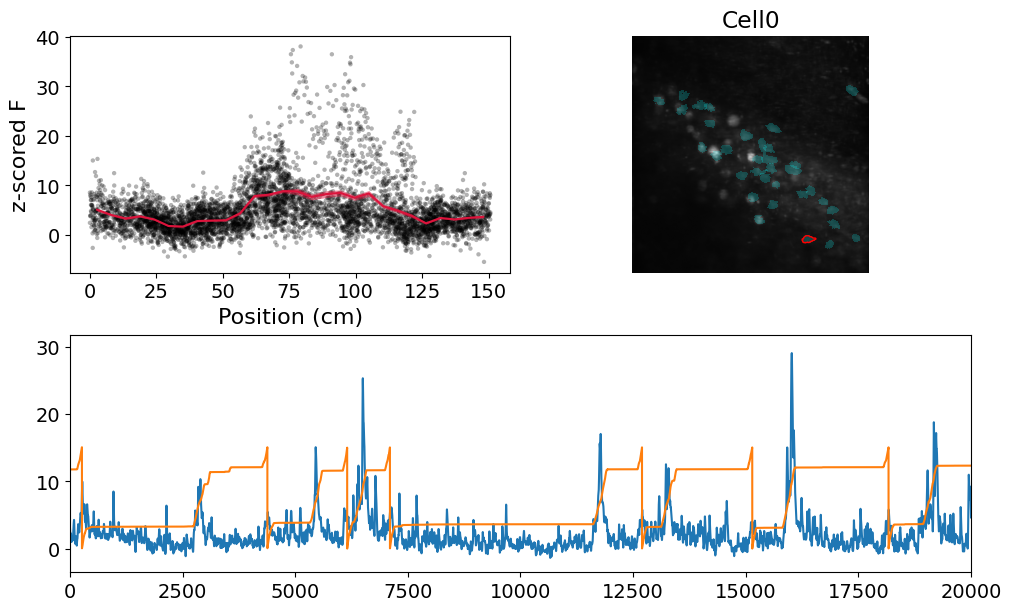

In [86]:
from scipy.ndimage import gaussian_filter
savefigure = True
# c_manual = [target[0][0]]
# c_manual = range(ca_all.shape[0])
c_manual = [0]
for c in c_manual:
    cellID = c

    fig = plt.figure(figsize=(10, 6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=len(dates)+1)
    ts=range(len(dates))
    for t in ts:
        ax = fig.add_subplot(gs[0, t])
        # ax = axs[t]
        print(mean_pos_tune_array_PC_all[t].shape)
        ax.scatter(position_all[t],ca_all_all[t][cellID, :] , edgecolors='none', color='k', vmin=0, vmax=10,s=10,alpha=0.3) # only under calcium, 1kHz spike train is noisy and mostly 1/0
        # plt.show()
        y = mean_pos_tune_array_all[t][cellID,:]
        err = se_pos_tune_array_all[t][cellID,:]
        ax.plot(bin_centers, y,'crimson')
        ax.fill_between(bin_centers, y-err, y+err, color='crimson', alpha=0.5,linewidth=0)
        ax.set_xlabel("Position (cm)",fontsize=16)
        ax.set_ylabel("z-scored F",fontsize=16)
        # ax.set_xticks(fontsize=14)
        # ax.set_yticks(fontsize=14)
    # plt.show()

    ## cell position
    ops, stat, iscell_2 = load_suite2p_plane(foldername)
    Ly, Lx = int(ops["Ly"]), int(ops["Lx"])
    masks, idx = build_roi_masks(stat, Ly, Lx, use_iscell=use_iscell, iscell=iscell_2)
    # Optional shift if XAML coords are in cropped coords
    x0 = int(ops["xrange"][0]) if ("xrange" in ops and xaml_is_cropped_view) else 0
    y0 = int(ops["yrange"][0]) if ("yrange" in ops and xaml_is_cropped_view) else 0

    ax = fig.add_subplot(gs[0, t+1])
    ax.imshow(meanImg, cmap='gray', vmin=0, vmax=1300)
    ax.axis('off')
    # --- overlay suite2p mask contours (resized to your image) ---

    for m in masks:
        m2 = resize_mask_nn(m, 512, 512)
        ax.contourf(m2.astype(float), levels=[0.7,1], colors="cyan", alpha=0.2, linewidths=1.0)

    m3 = resize_mask_nn(masks[cellID,:,:], 512, 512)
    ax.contour(m3.astype(float), levels=[0.7], colors="red", linewidths=1.0)
    ax.set_title("Cell"+str(cellID))
    # plt.show()
    showrange=[0,20000]

    ax = fig.add_subplot(gs[1, :])
    ax.plot(gaussian_filter(F_zs_each[0][cellID,:], sigma=5))
    ax.plot(ds_oephys_data[t][0,:]/10)
    ax.set_xlim(showrange)
    if savefigure:
        fig.savefig(foldername+"/"+str(cellID)+".png", dpi=300, bbox_inches="tight")
    plt.show()


In [47]:
print(target)

(array([23]),)


In [76]:


# ca_zs = stats.zscore(ca_all, axis=1)

ca_PC = ca_all[mean_pos_tune_array_PC,:] # running only
ca_nPC = ca_all[mean_pos_tune_array_nPC,:]
pos_show = position


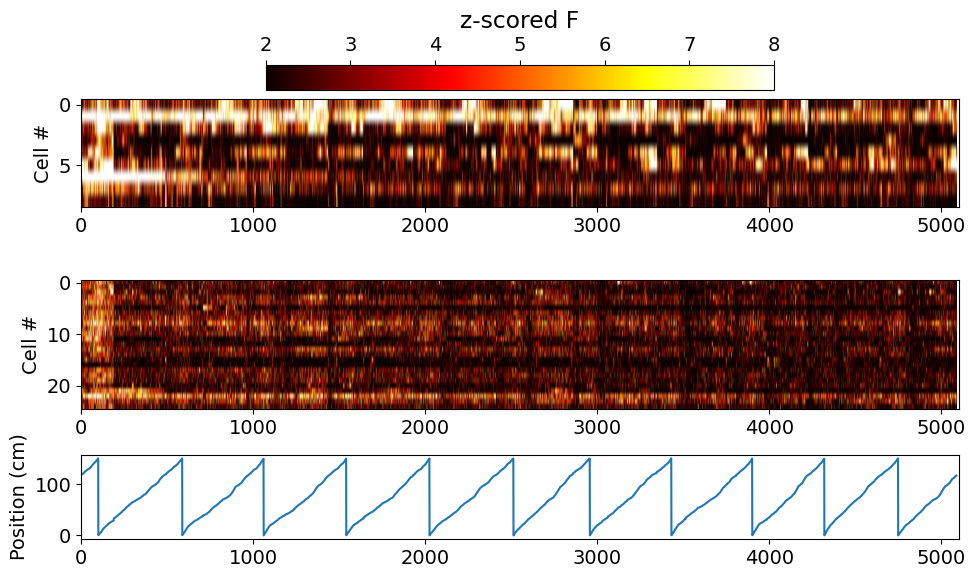

In [ ]:

# ca_PC = F_all_trunc[mean_pos_tune_array_PC,:] #all
# ca_nPC = F_all_trunc[mean_pos_tune_array_nPC,:]
# pos_show = ds_pos

F_all_trunc_sort = ca_PC[tune_idx_sort,:]

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(3, 1, figsize=(10, 6),gridspec_kw={'height_ratios': [2,2, 1]})
showrange = [0,5100]
vmin = 2
vmax = 8
h = ax[0].imshow(F_all_trunc_sort, vmin=vmin, vmax=vmax,cmap='hot',aspect=70)
ax[0].set_ylabel('Cell #')
clb = fig.colorbar(h, orientation='horizontal',location='top')
clb.ax.set_title('z-scored F')
ax[0].set_xlim(showrange)



h = ax[1].imshow(ca_nPC, vmin=vmin, vmax=vmax,cmap='hot',aspect=30)
ax[1].set_ylabel('Cell #')
ax[1].set_xlim(showrange)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


ax[2].plot(pos_show)
ax[2].set_xlim(showrange)#(0, F_all_trunc_sort.shape[1])
ax[2].set_ylabel('Position (cm)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [550]:
#bayesian decoding
spatial_bin = 1
step = 1
bin_scale_factor = pos_max/nbins
spkraster = ca_PC
posFR_all = mean_pos_tune_array[mean_pos_tune_array_PC,:]
print(spkraster.shape)
p_x_n = bayes.BayesianDecoder(spkraster,posFR_all,spatial_bin,step,20,include_end=False)

(24, 72516)


In [197]:
print(pos_min)

0.0


(3625,)


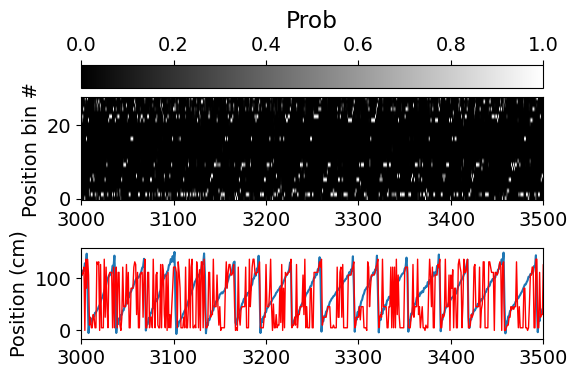

(28, 3625)


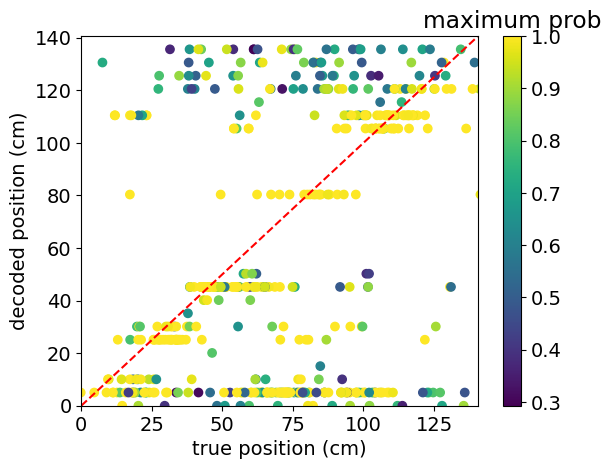

In [555]:
pos_bin = scipy.signal.resample(position,p_x_n.shape[1])
print(pos_bin.shape)

fig, ax = plt.subplots(2, 1, figsize=(6, 4),gridspec_kw={'height_ratios': [2, 1]})
showrange = [3000,3500]

h = ax[0].imshow(p_x_n, vmin=0, vmax=1,cmap='gray',aspect=4,origin='lower')
ax[0].set_ylabel('Position bin #')
clb = fig.colorbar(h, orientation='horizontal',location='top')
clb.ax.set_title('Prob')
ax[0].set_xlim(showrange)
# plt.colorbar()
# plt.show()
ax[1].plot(pos_bin)
ax[1].set_xlim(showrange)
ax[1].set_ylabel('Position (cm)')
ax[1].plot(np.argmax(p_x_n, axis=0)*bin_scale_factor,"r", linewidth=1)
plt.tight_layout()
plt.show()
plt.scatter(pos_bin[showrange[0]:showrange[1]],np.argmax(p_x_n[:,showrange[0]:showrange[1]], axis=0)*bin_scale_factor,c=np.max(p_x_n[:,showrange[0]:showrange[1]], axis=0))
plt.xlabel("true position (cm)")
plt.ylabel("decoded position (cm)")
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.xlim([0,pos_max])
plt.ylim([0,pos_max])
clb2 = plt.colorbar()
clb2.ax.set_title('maximum prob')
print(p_x_n.shape)
